# <span style="color:blue">Post-workshop 6A discussion: Basic neural evolution with XOR</span>

Simon O'Keefe: simon.okeefe@york.ac.uk

Danny Roberts: danny.roberts@york.ac.uk

Tianda Sun: tianda.sun@york.ac.uk

## <span style="color:#0073e6">Prerequisites</span>

Before participating in this practical make sure that you have watched the neural network lectures

## <span style="color:#0073e6">Topics</span>

- Basic neural evolution

## <span style="color:#0073e6">Learning objectives</span>

- To understand how to evolve weights in a static topology neural network


# <span style="color:blue">Practical instructions</span>

In this practical you will evolve weights of a simple MLP. The problem that you will address is the 'exclusive OR' problem (XOR). We are using this problem, because it is simple, yet it is known that a hidden layer is needed in a MPL to solve this provlem because it is not linearly seperable. The XOR problem takes in two binary inputs and outputs a 1 if either are a one, but not both:

<img src="xor.png" alt="xor" width=160>

Don't worry; you will get to have a go at a more complex game example soon!

# <span style="color:blue">Defining a simple neural network</span>

There are packages out there dedicated to producing neural networks, such as Tensorflow and Pytorch. However, for simplicity we will implement our own basic MLP, fully-connected and hard-coded with just one hidden layer. This is implemented the same as in the walkthrough.

<img src="MLP.jpg" alt="MLP" width=400>

Let's start by defining a class for our network:

In [1]:
import numpy as np
import math

class MLP(object):
    def __init__(self, numInput, numHidden, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node to inputs
        self.numHidden = numHidden
        self.numOutput = numOutput

        self.wh = np.random.randn(self.numHidden, self.numInput) 
        self.wo = np.random.randn(self.numOutput, self.numHidden)

        self.ReLU = lambda x : max(0,x)

    def sigmoid(self,x):
        try:
            ans = (1 / (1 + math.exp(-x)))
        except OverflowError:
            ans = float('inf')
        return ans

First we define the feedforward function of our network. To do this, we simply take the dot product of the input array and the weights from that input to the next layer of nodes. We then run those weighted sums through the ReLU function in the hidden layer, and the sigmoid in the last layer. This makes it similar to a non-linear regression problem.

In [2]:
class MLP(MLP):
    def feedForward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)                 # Add bias input
        h1 = np.dot(self.wh, inputsBias)                 # feed to hidden layer
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer
        output = np.dot(self.wo, h1)                 # feed to output layer
        output = [self.sigmoid(x) for x in output]   # Activate output layer
        return output

Next we define functions that allow the genetic algorithm to get and set the weights as a simple one-dimensional list. This means we can then just work with the built-in operators without having to worry about defining our own to work with multidimensional arrays.

In [3]:
class MLP(MLP):
    
    def getWeightsLinear(self):
        flat_wh = list(self.wh.flatten())
        flat_wo = list(self.wo.flatten())
        return( flat_wh + flat_wo )

    def setWeightsLinear(self, Wgenome):
        numWeights_IH = self.numHidden * (self.numInput)
        self.wh = np.array(Wgenome[:numWeights_IH])
        self.wh = self.wh.reshape((self.numHidden, self.numInput))
        self.wo = np.array(Wgenome[numWeights_IH:])
        self.wo = self.wo.reshape((self.numOutput, self.numHidden))

We will create a multi-layer perceptron with 2 inputs, 3 hidden nodes (here in a single hidden layer), and 1 output. 

In [4]:
myNet = MLP(2,3,1)

In [5]:
a = myNet.getWeightsLinear()

It takes in a list of size 2, and gives a list as output, with each element in the list being the output nodes (here we only have 1).

In [6]:
inputs = [0,1]

In [7]:
outcome = myNet.feedForward(inputs)

The outcome will be between 0 and 1, due to the sigmoid function. To make this binary we can add a step function.

In [8]:
print(outcome)

[0.5431873319595386]


In [9]:
int(outcome[0] > 0.5)

1

# <span style="color:blue">The Genetic Algorithm</span>

One approach could be to create a population of neural networks. However, that might be slow (and involve using copy.deepcopy) and not allow you to use DEAP's built in operators. Instead, we will evolve a population of flat lists, representing the neural network weights. We will onlu need to instantiate a single neural network to evaluate the fitness of those weights.

In [10]:
import random

from deap import base
from deap import creator
from deap import tools

In [11]:
numInputNodes = 2 + 1
numHiddenNodes = 3
numOutputNodes = 1

IND_SIZE = (numInputNodes * numHiddenNodes) + (numHiddenNodes * numOutputNodes)

In [18]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

/usr/local/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [19]:
def evaluate(indiv, myNet):
    fitness = 0
    myNet.setWeightsLinear(indiv)
    output = myNet.feedForward([0,0])
    fitness += abs( 0 - output[0] ) 
    output = myNet.feedForward([0,1])
    fitness += abs( 1 - output[0] ) 
    output = myNet.feedForward([1,0])
    fitness += abs( 1 - output[0] ) 
    output = myNet.feedForward([1,1])
    fitness += abs( 0 - output[0] ) 
    return fitness,

In [20]:
toolbox.register("evaluate", evaluate)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.5, indpb=0.1)

In [21]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [22]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [32]:
logbook = tools.Logbook()

pop = toolbox.population(n=500)

fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

NGEN, CXPROB = 200, 0.0

for g in range(NGEN):
    print("-- Generation %i --" % g)
      
    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))


    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
                         
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(indiv, myNet) for indiv in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit

    pop[:] = offspring
    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
-- Generation 26 --
-- Generation 27 --
-- Generation 28 --
-- Generation 29 --
-- Generation 30 --
-- Generation 31 --
-- Generation 32 --
-- Generation 33 --
-- Generation 34 --
-- Generation 35 --
-- Generation 36 --
-- Generation 37 --
-- Generation 38 --
-- Generation 39 --
-- Generation 40 --
-- Generation 41 --
-- Generation 42 --
-- Generation 43 --
-- Generation 44 --
-- Generation 45 --
-- Generation 46 --
-- Generation 47 --
-- Generation 48 --
-- Generation 49 --
-- Generat

# Quick examination of the algorithm

In [33]:
logbook.header = "gen", "avg", "evals", "std", "min", "max"

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
gen = logbook.select("gen")
avgs = logbook.select("avg")
stds = logbook.select("std")

Text(0, 0.5, 'Mean Fitness')

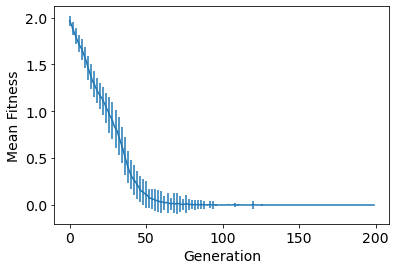

In [35]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
#line1 = ax1.plot(gen, avgs)
line1 = ax1.errorbar(gen, avgs, yerr=stds, errorevery=2)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Fitness")

# Test the solutions

In [36]:
indiv1 = tools.selBest(pop, 1)[0]
myNet.setWeightsLinear(indiv1)

In [37]:
outcome = myNet.feedForward([0,0])
int(outcome[0] > 0.5)

0

In [38]:
outcome = myNet.feedForward([0,1])
int(outcome[0] > 0.5)

1

In [39]:
outcome = myNet.feedForward([1,0])
int(outcome[0] > 0.5)

1

In [40]:
outcome = myNet.feedForward([1,1])
int(outcome[0] > 0.5)

0

# <span style="color:blue">Optional exercise</span>

If you complete the above and fancy an additional challange, you could try adding a bias node to the hidden layer, or using Tensorflow.